In [1]:
import pandas as pd
import json
from konlpy.tag import Okt
from pykospacing import Spacing
import re
from collections import Counter
from tqdm import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt

/tmp/ipykernel_222168/4220352391.py:2: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


## 1. 더 글로리 키워드를 이용한 단어 빈도수에 대한 분석

### 분석을 위한 패키지를 준비한다.

In [2]:
# konlpy의 트위터 기반 토크나이저 패키지
okt = Okt()
# 딥 러닝 기반의 한글 띄어쓰기 교정 모형
spacing = Spacing()
# 한글과 띄어쓰기만을 이용하기 위한 정규식
regex_string = "[^ 가-힣+]"
# 한글 폰트 사용
# sudo apt-get install fonts-nanum fonts-nanum-coding fonts-nanum-extra
# 워드 클라우드
wordcloud = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumSquareR.ttf', max_font_size=100, max_words=1000, margin=4)

### 불용어 처리를 위한 불용어 사전을 준비한다.

자연어 처리에서 한국어는 주요한 언어가 아니기 때문에, nltk 등 유명 라이브러리 등에 자체적으로 탑재되어 있지 않다.<br>
따라서, 한국어만을 위한 불용어 사전을 아래 출처로부터 가져와 활용하였다.

출처: https://www.ranks.nl/stopwords/korean

In [12]:
# 불용어 사전을 통한 불용어 처리 
with open("twitter/stopwords.txt", "r") as f:
    contents = f.readlines()

# 불용어 집합 생성
# 마지막 글자는 개행이므로 제거
stopwords = set([word[:-1] for word in contents])

### 데이터 분석에서는 데이터프레임 기반의 방식이 편리하므로, pandas 패키지를 이용한다.

In [4]:
df_glory = pd.read_json("twitter/the_glory.json")

주어진 json 파일로부터 다음과 같은 정보들을 가져올 수 있다.

In [5]:
df_glory.columns

Index(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities',
       'extended_entities', 'metadata', 'source', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo',
       'coordinates', 'place', 'contributors', 'retweeted_status',
       'is_quote_status', 'retweet_count', 'favorite_count', 'favorited',
       'retweeted', 'possibly_sensitive', 'lang', 'quoted_status_id',
       'quoted_status_id_str'],
      dtype='object')

데이터 프레임은 다음과 같이 구성된다.

In [13]:
df_glory.head()

,created_at,id,id_str,text,truncated,entities,extended_entities,metadata,source,in_reply_to_status_id,...,retweeted_status,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,quoted_status_id,quoted_status_id_str
0,2023-03-15 15:13:24+00:00,1636022791853195264,1636022791853195264,RT @season__22: 아 더글로리 악역들 화보 떴대서 들어갔는데 \n전재준 ...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1635979666975764481, 'id_str...","{'result_type': 'recent', 'iso_language_code':...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,{'created_at': 'Wed Mar 15 12:22:03 +0000 2023...,False,951,0,False,False,0.0,ko,NaN,NaN
1,2023-03-15 15:13:23+00:00,1636022791517671425,1636022791517671424,RT @sikie_d: 이도현 한 작품으로 두 가지 맛 보여주는 게 너무 좋음......,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"{'result_type': 'recent', 'iso_language_code':...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,{'created_at': 'Wed Mar 15 01:16:40 +0000 2023...,False,113,0,False,False,NaN,ko,NaN,NaN
2,2023-03-15 15:13:21+00:00,1636022781673623554,1636022781673623552,RT @only1intheearth: 전두환 손자 폭로에 관심을 가져야하는 이유는 ...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"{'result_type': 'recent', 'iso_language_code':...","<a href=""http://twitter.com/download/android"" ...",NaN,...,{'created_at': 'Wed Mar 15 03:45:35 +0000 2023...,True,22142,0,False,False,NaN,ko,1.635698e+18,1.635698e+18
3,2023-03-15 15:13:19+00:00,1636022772542619648,1636022772542619648,RT @only1intheearth: 전두환 손자 폭로에 관심을 가져야하는 이유는 ...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"{'result_type': 'recent', 'iso_language_code':...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,{'created_at': 'Wed Mar 15 03:45:35 +0000 2023...,True,22142,0,False,False,NaN,ko,1.635698e+18,1.635698e+18
4,2023-03-15 15:13:18+00:00,1636022767333281798,1636022767333281792,RT @loverdramas: 더 글로리 동은오적 화보 찢었다 https://t.c...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1635965867761766400, 'id_str...","{'result_type': 'recent', 'iso_language_code':...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,{'created_at': 'Wed Mar 15 11:27:14 +0000 2023...,False,9086,0,False,False,0.0,ko,NaN,NaN


### 텍스트로부터 단어 빈도수를 추출한다.

빈도를 세기 위해 dictionary 자료구조를 상속받은 Counter 자료구조를 이용한다.

In [8]:
counter_word_freq = Counter()

한국어 처리의 경우 다양한 품사를 이용하여 분석이 가능하다.<br>
가장 많이 활용되는 것은 형태소와 명사인데, 본 분석에서는 형태소와 명사를 이용하여 분석했다.

형태소는 모든 언어 처리에서 가장 많이 활용되는 품사이다.
보편적으로 풍부한 정보를 가지고 있다.

한국어에서 명사는 어떠한 행위 자체를 포함하는 경우가 많다.
예를 들어, 운동하다-운동, 공부하다-공부 등, 명사가 함유하고 있는 뜻이 풍부하여 명사만으로도 충분히 데이터를 분석할 수 있다.

In [22]:
full_list = [[], []]
for i, row in tqdm(df_glory.iterrows()):
    # 한글만 사용하기 위한 정규식
    text = re.sub(regex_string, '', row.text)
    
    # 딥러닝 기반의 띄어쓰기 교정 모형
    # text = spacing(row.text)
    
    # okt를 사용하여 텍스트를 정규화
    # 정규화 예시: 안녕하세욬ㅋㅋㅋ -> 안녕하세요ㅋㅋㅋ
    text = okt.normalize(text)
    
    # 정규화된 텍스트로부터 명사만 추출하여 빈도를 분석
    nouns_list = [word for word in okt.nouns(text) if len(word) > 1 and word not in stopwords]
    morphs_list = [word for word in okt.morphs(text) if len(word) > 1 and word not in stopwords]
    
    full_list[0].extend(nouns_list)
    full_list[1].extend(morphs_list)

1100it [00:05, 209.62it/s]


명사만을 이용하여 추출한 경우, 다음과 같다.

In [30]:
counter_word_freq = Counter(full_list[0])
print(counter_word_freq.most_common()[:10])

[('글로리', 1101), ('신예은', 469), ('폭로', 378), ('화보', 316), ('에피소드', 253), ('실제', 253), ('동은이', 252), ('장면', 245), ('공개', 238), ('세상', 238)]


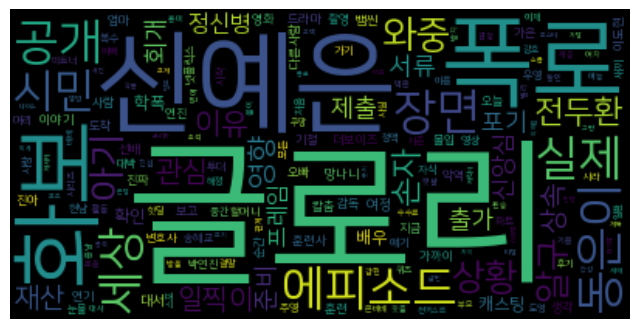

In [31]:
wordcloud.generate_from_frequencies(counter_word_freq)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

형태소만을 이용하여 추출한 경우, 다음과 같다.

In [32]:
counter_word_freq = Counter(full_list[1])
print(counter_word_freq.most_common()[:10])

[('글로리', 1101), ('신예은', 469), ('폭로', 378), ('화보', 316), ('찢었다', 274), ('에피소드', 253), ('실제', 253), ('동은이', 252), ('장면', 245), ('공개', 238)]


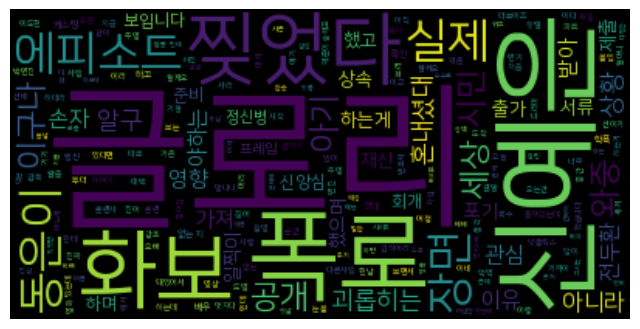

In [33]:
wordcloud.generate_from_frequencies(counter_word_freq)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

두 방식 모두 큰 차이가 있지는 않았으나, 형태소 기반 분석에서 "찢었다" 라는 밈이 추가되었다.<br>
이는, 트위터와 같은 온라인 커뮤니티에서는 보편적인 단어 사용보다 다양한 어휘를 다양하게 사용하는 것으로부터 비롯되었다고 할 수 있다.

## 더 글로리 키워드를 이용한 리트윗에 대한 분석

### 전체 데이터 (1100건) 중 리트윗의 개수

In [49]:
df_glory['is_rt'] = df_glory['text'].apply(lambda x: x.split()[0] == 'RT')
sum(df_glory['is_rt'])

1008

전체 데이터 중 1008건이 리트윗 데이터이다.<br>
1008건의 리트윗 데이터 중, 중복되지 않은 값은 몇개가 있는지 확인한다.

In [52]:
df_glory[df_glory['is_rt'] == True]['text'].unique().shape[0]

101

In [55]:
df_glory[df_glory['is_rt'] == True]['text'].unique()[:5]

array(['RT @season__22: 아 더글로리 악역들 화보 떴대서 들어갔는데 \n전재준 ㅋㅋㅋㅋㅋㅋ https://t.co/jXrje05GaR',
       'RT @sikie_d: 이도현 한 작품으로 두 가지 맛 보여주는 게 너무 좋음... 가성비 오지잖아\n18어게인 홍대영 고우영 멜랑꼴리아 고딩승유 성인승유 더글로리 썬키스트 스릴러에 이은 나쁜엄마 검사강호 7살강호 \n아 진짜 천재 아님? https:/…',
       'RT @only1intheearth: 전두환 손자 폭로에 관심을 가져야하는 이유는 더 글로리의 영향을 받아 폭로하는게 아니라 일찍이 재산 상속포기를 했고 출가했으며 이 또한 서류로 제출. 신앙심으로 회개하며 준비한 것으로 보입니다. 정신병 프레임을…',
       'RT @loverdramas: 더 글로리 동은오적 화보 찢었다 https://t.co/ahK1T1ipet',
       'RT @aboutloveknot: 신예은이 공개한 더 글로리 에피소드...🥺\n\n아기 동은이 괴롭히는 장면 찍을 때 어떤 시민분이 실제 상황인줄 알구 혼내셨대 ㅠㅠ 그 와중에 신예은 .•o (살 만한 세상이구나...) https://t.co/pXZef…'],
      dtype=object)

즉, 1008건의 리트윗이 발생했지만, 실제 트윗의 개수는 101건이다.<br>
더 글로리에 한정해서, 평균적으로 10개의 리트윗이 발생했다고 할 수 있다.

### 리트윗 데이터에 대한 단어 분석

In [59]:
unique_rt_text = df_glory[df_glory['is_rt'] == True]['text'].unique()

full_list = [[], []]
for text in tqdm(unique_rt_text):
    # 한글만 사용하기 위한 정규식
    text = re.sub(regex_string, '', text)
    
    # 딥러닝 기반의 띄어쓰기 교정 모형
    # text = spacing(row.text)
    
    # okt를 사용하여 텍스트를 정규화
    # 정규화 예시: 안녕하세욬ㅋㅋㅋ -> 안녕하세요ㅋㅋㅋ
    text = okt.normalize(text)
    
    # 정규화된 텍스트로부터 명사만 추출하여 빈도를 분석
    nouns_list = [word for word in okt.nouns(text) if len(word) > 1 and word not in stopwords]
    morphs_list = [word for word in okt.morphs(text) if len(word) > 1 and word not in stopwords]
    
    full_list[0].extend(nouns_list)
    full_list[1].extend(morphs_list)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 142.33it/s]


In [64]:
counter_word_freq = Counter(full_list[0])
print(counter_word_freq.most_common()[:10])

[('글로리', 106), ('동은이', 11), ('여정', 11), ('화보', 10), ('파트', 10), ('사람', 10), ('연진', 9), ('엄마', 7), ('생각', 7), ('진짜', 6)]


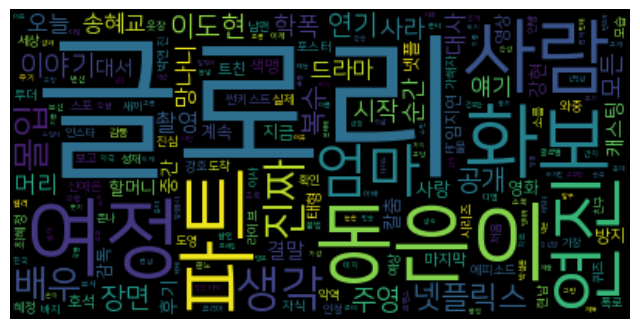

In [65]:
wordcloud.generate_from_frequencies(counter_word_freq)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [66]:
counter_word_freq = Counter(full_list[1])
print(counter_word_freq.most_common()[:10])

[('글로리', 106), ('동은이', 11), ('여정', 11), ('화보', 10), ('파트', 10), ('사람', 10), ('연진', 9), ('재준', 7), ('엄마', 7), ('하고', 7)]


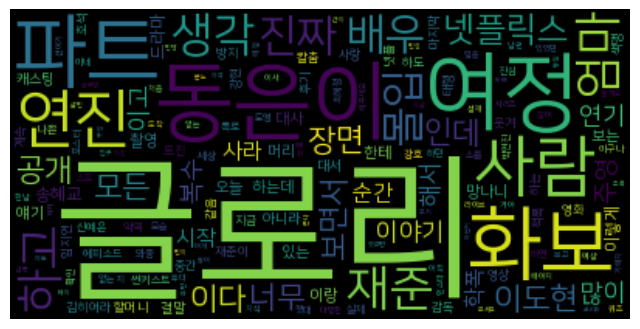

In [67]:
wordcloud.generate_from_frequencies(counter_word_freq)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

트위터를 하는 사람들은 주로 동은이와 연진, 여정, 재준 등 캐릭터에 대한 관심이 많은 것을 알 수 있다. <br>
또한, 최근 더 글로리에서 촬영한 화보에 대해서도 관심이 많음을 알 수 있다.

## 2. 강아지 키워드를 이용한 단어 빈도수에 대한 분석

In [70]:
df_dog = pd.read_json("twitter/dog.json")

In [72]:
df_dog.head()

,created_at,id,id_str,text,truncated,entities,extended_entities,metadata,source,in_reply_to_status_id,...,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,quoted_status_id,quoted_status_id_str,quoted_status
0,2023-03-15 06:11:36+00:00,1635886447306903552,1635886447306903552,RT @day_off_daying: 버려진 강아지를 찾는 전단지를 보고 연락해본 결...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1635655427223592963, 'id_str...","{'result_type': 'recent', 'iso_language_code':...","<a href=""http://twitter.com/download/android"" ...",NaN,...,False,1612,0,False,False,0.0,ko,NaN,NaN,NaN
1,2023-03-15 06:11:33+00:00,1635886433662820353,1635886433662820352,... 사실 여기 코는 강아지한테 맞아서 다친 거지만요...?!,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"{'result_type': 'recent', 'iso_language_code':...","<a href=""http://twittbot.net/"" rel=""nofollow"">...",NaN,...,False,0,0,False,False,NaN,ko,NaN,NaN,NaN
2,2023-03-15 06:11:33+00:00,1635886432907829249,1635886432907829248,RT @wwlake: 세븐틴 강아지 정모하는거 보고싶음 https://t.co/NU...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1635858370954657792, 'id_str...","{'result_type': 'recent', 'iso_language_code':...","<a href=""http://twitter.com/download/android"" ...",NaN,...,False,754,0,False,False,0.0,ko,NaN,NaN,NaN
3,2023-03-15 06:11:32+00:00,1635886429749534720,1635886429749534720,RT @1_0veyajj: 원우 오자마자 도어락 소리 듣고 현관으로 뛰어가는 강아지...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1635885899228798976, 'id_str...","{'result_type': 'recent', 'iso_language_code':...","<a href=""http://twitter.com/download/android"" ...",NaN,...,False,5,0,False,False,0.0,ko,NaN,NaN,NaN
4,2023-03-15 06:11:32+00:00,1635886426805116928,1635886426805116928,RT @wwlake: 세븐틴 강아지 정모하는거 보고싶음 https://t.co/NU...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1635858370954657792, 'id_str...","{'result_type': 'recent', 'iso_language_code':...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,754,0,False,False,0.0,ko,NaN,NaN,NaN


In [73]:
counter_word_freq = Counter()

In [74]:
full_list = [[], []]
for i, row in tqdm(df_dog.iterrows()):
    # 한글만 사용하기 위한 정규식
    text = re.sub(regex_string, '', row.text)
    
    # 딥러닝 기반의 띄어쓰기 교정 모형
    # text = spacing(row.text)
    
    # okt를 사용하여 텍스트를 정규화
    # 정규화 예시: 안녕하세욬ㅋㅋㅋ -> 안녕하세요ㅋㅋㅋ
    text = okt.normalize(text)
    
    # 정규화된 텍스트로부터 명사만 추출하여 빈도를 분석
    nouns_list = [word for word in okt.nouns(text) if len(word) > 1 and word not in stopwords]
    morphs_list = [word for word in okt.morphs(text) if len(word) > 1 and word not in stopwords]
    
    full_list[0].extend(nouns_list)
    full_list[1].extend(morphs_list)

1100it [00:05, 204.03it/s]


In [80]:
counter_word_freq = Counter(full_list[0])
print(counter_word_freq.most_common()[:10])

[('강아지', 1213), ('이름', 295), ('전설', 178), ('레전드', 140), ('세븐', 116), ('정모', 86), ('고양이', 85), ('보고', 78), ('진짜', 54), ('원우', 42)]


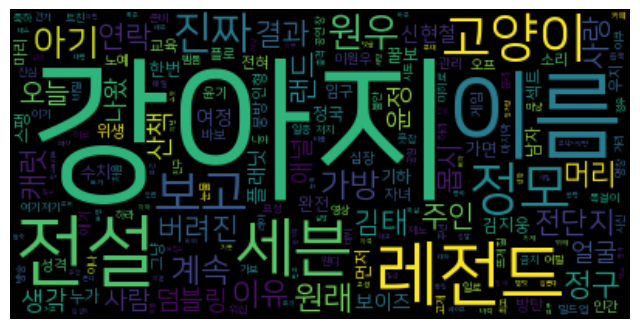

In [76]:
wordcloud.generate_from_frequencies(counter_word_freq)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [77]:
counter_word_freq = Counter(full_list[1])
print(counter_word_freq.most_common()[:10])

[('강아지', 1213), ('이름', 295), ('전설', 178), ('레전드', 140), ('미치겠네', 138), ('세븐', 116), ('하는거', 93), ('정모', 86), ('보고싶음', 86), ('고양이', 85)]


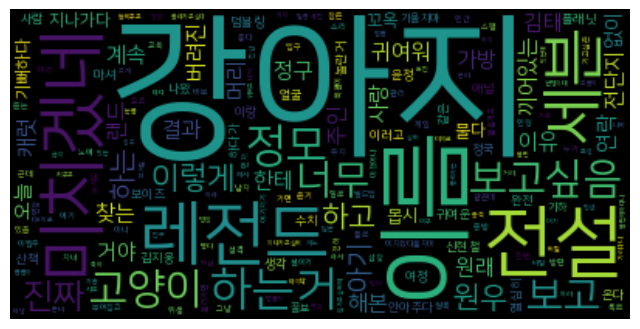

In [78]:
wordcloud.generate_from_frequencies(counter_word_freq)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### 강아지 키워드에 대한 리트윗 분석

In [81]:
df_dog['is_rt'] = df_dog['text'].apply(lambda x: x.split()[0] == 'RT')
sum(df_dog['is_rt'])

868

In [82]:
df_dog[df_dog['is_rt'] == True]['text'].unique().shape[0]

265

In [83]:
df_dog[df_dog['is_rt'] == True]['text'].unique()[:5]

array(['RT @day_off_daying: 버려진 강아지를 찾는 전단지를 보고 연락해본 결과 https://t.co/uKkdXavKiK',
       'RT @wwlake: 세븐틴 강아지 정모하는거 보고싶음 https://t.co/NUs9LSkzli',
       'RT @1_0veyajj: 원우 오자마자 도어락 소리 듣고 현관으로 뛰어가는 강아지마냥 숟가락 내려놓고 댓글 읽는거봐ㅋㅋㅋㅋㅋㅠㅠㅜㅜ 진짜 귀여워 쫑아지\U0001f979 https://t.co/LaJGaHNWzA',
       'RT @MIRO_to823: 7화 예고 로토\n두손 꼭 모으고 마스터님 말씀 듣는 강아지ㅠㅠ\n#イクミにいく\n#히로토 #이쿠미히로토 #HIROTO #ikumihiroto #井汲大翔 #いくみひろと https://t.co/4wjNk1koUG',
       'RT @lover_406: 공연장 여기저기 다 가고싶은 강아지 빌드업 미쳤어ㅋㅋㅋㅋ\n"나 일로가면 (1층올라가면) 안붙을거죠?"\n"나 여기 지나가고싶어"\n"일층 올라가고싶다"\n\n틈틈히 계속 어필하다가 저지 덜 받을거같은  플로어 입구쪽 한번 먼저가보…'],
      dtype=object)

앞선 워드 클라우드에서 등장한 세븐이라는 단어는 실제 세븐을 의미하는 것이 아니라, 세븐틴을 의미하고 있음을 데이터를 통해 확인할 수 있다.<br>
명사 중 원우 키워드 또한 세븐틴의 멤버 원우를 지칭한다.<br>
또한 리트윗된 내용을 보면 세븐틴의 정한 멤버에 대한 내용이다.<br>
실제 관심 있는 키워드는 강아지이지만, 강아지와 전혀 연관 없는 트윗들이 굉장히 많이 등장함을 알 수 있다.

강아지 키워드의 경우 더 글로리보다 리트윗의 개수가 적으며, 더 많은 유일한 트윗의 개수가 있다.<br>
이를 토대로, 더 글로리가 더 빠르게 리트윗되고 더 많은 관심을 가짐을 알수 있다.

In [84]:
unique_rt_text = df_dog[df_dog['is_rt'] == True]['text'].unique()

full_list = [[], []]
for text in tqdm(unique_rt_text):
    # 한글만 사용하기 위한 정규식
    text = re.sub(regex_string, '', text)
    
    # 딥러닝 기반의 띄어쓰기 교정 모형
    # text = spacing(row.text)
    
    # okt를 사용하여 텍스트를 정규화
    # 정규화 예시: 안녕하세욬ㅋㅋㅋ -> 안녕하세요ㅋㅋㅋ
    text = okt.normalize(text)
    
    # 정규화된 텍스트로부터 명사만 추출하여 빈도를 분석
    nouns_list = [word for word in okt.nouns(text) if len(word) > 1 and word not in stopwords]
    morphs_list = [word for word in okt.morphs(text) if len(word) > 1 and word not in stopwords]
    
    full_list[0].extend(nouns_list)
    full_list[1].extend(morphs_list)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 160.44it/s]


In [85]:
counter_word_freq = Counter(full_list[0])
print(counter_word_freq.most_common()[:10])

[('강아지', 284), ('고양이', 24), ('아기', 19), ('진짜', 14), ('보고', 11), ('사랑', 10), ('계속', 9), ('김태', 9), ('오늘', 9), ('사람', 8)]


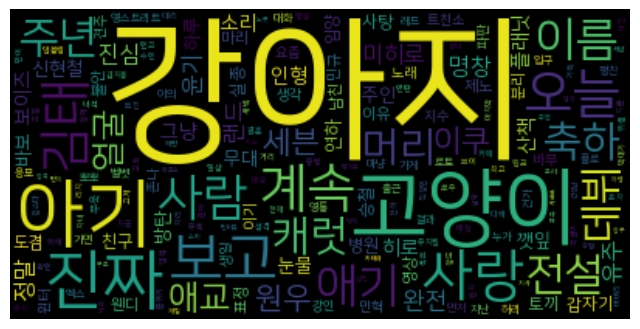

In [86]:
wordcloud.generate_from_frequencies(counter_word_freq)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [87]:
counter_word_freq = Counter(full_list[1])
print(counter_word_freq.most_common()[:10])

[('강아지', 284), ('너무', 37), ('고양이', 24), ('아기', 19), ('하는', 16), ('진짜', 14), ('보고', 11), ('귀여워', 11), ('사랑', 10), ('하고', 10)]


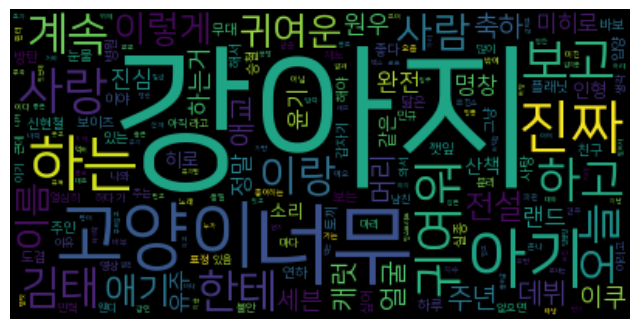

In [88]:
wordcloud.generate_from_frequencies(counter_word_freq)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

데이터 분석이 이론과 실재가 멀다는 것을 느꼈다.<br>
더 글로리의 분석은 일부 납득가능한 내용들이 있었으나, 특히, 강아지 분석에서 세븐틴과 관련된 자료들은 강아지 키워드를 분석함과 연관성이 없다.<br>
딥 러닝의 학습 데이터도 마찬가지이지만, 빅데이터 자체에 집중하기보다는 실제 데이터의 퀄리티가 중요함을 여실히 보여주는 결과였다.